In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip gdrive/My\ Drive/data/Dataset.zip

In [3]:
import numpy as np
import pandas as pd
import os, math, sys
import glob, itertools
import argparse, random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.models import vgg19
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import save_image, make_grid
from torchvision.transforms import ToTensor

import plotly
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split

random.seed(42)
import warnings
warnings.filterwarnings("ignore")

In [4]:
load_pretrained_models = True
n_epochs = 10
dataset_path = "/content/Dataset"
batch_size = 1
lr = 0.0001
b1 = 0.5
b2 = 0.999
decay_epoch = 100
n_cpu = 8
hr_height = 256
hr_width = 256
channels = 1

os.makedirs("images", exist_ok=True)
os.makedirs("saved_models", exist_ok=True)

cuda = torch.cuda.is_available()
hr_shape = (hr_height, hr_width)
print(cuda)

True


In [5]:
class ImageDataset(Dataset):
    def __init__(self, files, hr_shape):
        hr_height, hr_width = hr_shape
        self.lr_transform = transforms.Compose(
            [
                transforms.Resize((hr_height // 4, hr_height // 4), Image.BICUBIC),
                transforms.Grayscale(num_output_channels=1),
                transforms.ToTensor(),
            ]
        )
        self.hr_transform = transforms.Compose(
            [
                transforms.Resize((hr_height, hr_height), Image.BICUBIC),
                transforms.Grayscale(num_output_channels=1),
                transforms.ToTensor(),
            ]
        )
        self.files = files
    
    def __getitem__(self, index):
        img = Image.open(self.files[index % len(self.files)]).convert('RGB')
        img_lr = self.lr_transform(img)
        img_hr = self.hr_transform(img)
            
        return {"lr": img_lr, "hr": img_hr}
    
    def __len__(self):
        return len(self.files)


# Mapping LR images to their corresponding HR images

In [6]:
import os
import random
import shutil

# Set the paths to the dataset folder and the LR and HR subfolders
dataset_path = "/content/Dataset"
lr_path = os.path.join(dataset_path, "LR")
hr_path = os.path.join(dataset_path, "HR")

# Create the train and test folders
train_path = os.path.join(dataset_path, "train")
test_path = os.path.join(dataset_path, "test")
os.makedirs(train_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)

# Get the list of LR and HR image filenames
lr_filenames = os.listdir(lr_path)
hr_filenames = os.listdir(hr_path)

# Shuffle the list of filenames
random.shuffle(lr_filenames)

# Map the LR images to their respective HR images
image_map = {}
for lr_filename in lr_filenames:
    hr_filename = lr_filename.replace("_LR", "")
    image_map[lr_filename] = hr_filename

# Split the dataset into train and test sets
num_train = int(len(lr_filenames) * 0.9)
train_lr_filenames = lr_filenames[:num_train]
test_lr_filenames = lr_filenames[num_train:]

# Copy the LR and HR images to the train and test folders
for lr_filename in train_lr_filenames:
    hr_filename = image_map[lr_filename]
    shutil.copy(os.path.join(lr_path, lr_filename), os.path.join(train_path, lr_filename))
    shutil.copy(os.path.join(hr_path, hr_filename), os.path.join(train_path, hr_filename))
    
for lr_filename in test_lr_filenames:
    hr_filename = image_map[lr_filename]
    shutil.copy(os.path.join(lr_path, lr_filename), os.path.join(test_path, lr_filename))
    shutil.copy(os.path.join(hr_path, hr_filename), os.path.join(test_path, hr_filename))


# Converting images present in .npy format to .jpg format

In [ ]:
# Converting .npy images to .jpg images
import cv2
import numpy as np
input_dir = 'Dataset/test'
output_dir = 'Dataset2/test'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

for filename in os.listdir(input_dir):
    if filename.endswith(".npy"):
        # Load the .npy file
        image = np.load(os.path.join(input_dir, filename))
        # Reshape the image and convert to uint8
        image = np.squeeze(image)
        image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
        # Save the image as a .jpg file
        output_path = os.path.join(
            output_dir, os.path.splitext(filename)[0] + ".jpg")
        cv2.imwrite(output_path, image)


# Splitting the dataset into train and test

In [28]:
dataset_path='Dataset/'
train_paths = glob.glob(dataset_path + "train/*.*")
test_paths = glob.glob(dataset_path + "test/*.*")
train_dataloader = DataLoader(ImageDataset(train_paths, hr_shape=hr_shape), batch_size=batch_size, shuffle=True, num_workers=n_cpu)
test_dataloader = DataLoader(ImageDataset(test_paths, hr_shape=hr_shape), batch_size=1, shuffle=False, num_workers=n_cpu)

In [8]:
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        vgg19_model = vgg19(pretrained=True)
        self.feature_extractor = nn.Sequential(*list(vgg19_model.features.children())[:18])

    def forward(self, img):
      # If input image has 1 channel, repeat it 3 times to match VGG19 input
        if img.size(1) == 1:
            img = torch.cat([img, img, img], dim=1)
        return self.feature_extractor(img)


class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_features, in_features, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_features, 0.8),
            nn.PReLU(),
            nn.Conv2d(in_features, in_features, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_features, 0.8),
        )

    def forward(self, x):
        return x + self.conv_block(x)

In [9]:
class GeneratorResNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, n_residual_blocks=16):
        super(GeneratorResNet, self).__init__()

        # First layer
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels, 64, kernel_size=9, stride=1, padding=4), nn.PReLU())

        # Residual blocks
        res_blocks = []
        for _ in range(n_residual_blocks):
            res_blocks.append(ResidualBlock(64))
        self.res_blocks = nn.Sequential(*res_blocks)

        # Second conv layer post residual blocks
        self.conv2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1), nn.BatchNorm2d(64, 0.8))

        # Upsampling layers
        upsampling = []
        for out_features in range(2):
            upsampling += [
                # nn.Upsample(scale_factor=2),
                nn.Conv2d(64, 256, 3, 1, 1),
                nn.BatchNorm2d(256),
                nn.PixelShuffle(upscale_factor=2),
                nn.PReLU(),
            ]
        self.upsampling = nn.Sequential(*upsampling)

        # Final output layer
        self.conv3 = nn.Sequential(nn.Conv2d(64, out_channels, kernel_size=9, stride=1, padding=4), nn.Tanh())

    def forward(self, x):
        out1 = self.conv1(x)
        out = self.res_blocks(out1)
        out2 = self.conv2(out)
        out = torch.add(out1, out2)
        out = self.upsampling(out)
        out = self.conv3(out)
        return out

In [10]:
class Discriminator(nn.Module):
    def __init__(self, input_shape):
        super(Discriminator, self).__init__()

        self.input_shape = input_shape
        in_channels, in_height, in_width = self.input_shape
        patch_h, patch_w = int(in_height / 2 ** 4), int(in_width / 2 ** 4)
        self.output_shape = (1, patch_h, patch_w)

        def discriminator_block(in_filters, out_filters, first_block=False):
            layers = []
            layers.append(nn.Conv2d(in_filters, out_filters, kernel_size=3, stride=1, padding=1))
            if not first_block:
                layers.append(nn.BatchNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            layers.append(nn.Conv2d(out_filters, out_filters, kernel_size=3, stride=2, padding=1))
            layers.append(nn.BatchNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        layers = []
        in_filters = in_channels
        for i, out_filters in enumerate([64, 128, 256, 512]):
            layers.extend(discriminator_block(in_filters, out_filters, first_block=(i == 0)))
            in_filters = out_filters

        layers.append(nn.Conv2d(out_filters, 1, kernel_size=3, stride=1, padding=1))

        self.model = nn.Sequential(*layers)

    def forward(self, img):
        return self.model(img)

In [11]:
# Initialize generator and discriminator
generator = GeneratorResNet()
print(channels)
discriminator = Discriminator(input_shape=(channels, *hr_shape))
feature_extractor = FeatureExtractor()

# Set feature extractor to inference mode
feature_extractor.eval()

# Losses
criterion_GAN = torch.nn.MSELoss()
criterion_content = torch.nn.L1Loss()

if cuda:
    generator = generator.cuda()
    discriminator = discriminator.cuda()
    feature_extractor = feature_extractor.cuda()
    criterion_GAN = criterion_GAN.cuda()
    criterion_content = criterion_content.cuda()

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor

1


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [12]:
def to_np(x):
    return x.data.cpu().numpy()

# Function for comparison of images generated by Generator with original image

In [13]:
def plot_train_result(real_image, gen_image, recon_image, epoch=1, save=False, show=True, fig_size=(15, 15)):
    fig, axes = plt.subplots(1, 3, figsize=fig_size)
    imgs = [to_np(real_image), to_np(gen_image), to_np(recon_image)]
    for ax, img in zip(axes.flatten(), imgs):
        ax.axis('off')
        # Scale to 0-255
        img = img.squeeze()
        img = (((img - img.min()) * 255) / (img.max() - img.min())).astype(np.uint8)
        ax.imshow(img, cmap='gray', aspect='equal')
    plt.subplots_adjust(wspace=0, hspace=0)

    title = 'Epoch {0}'.format(epoch + 1)
    fig.text(0.5, 0.04, title, ha='center')

    # save figure
    if save:
        save_fn = 'Result_epoch_{:d}'.format(epoch+1) + '.png'
        plt.savefig(save_fn)

    if show:
        plt.show()
    else:
        plt.close()


# Training Loop

Training Epoch 0 :   0%|          | 0/9000 [00:00<?, ?it/s]

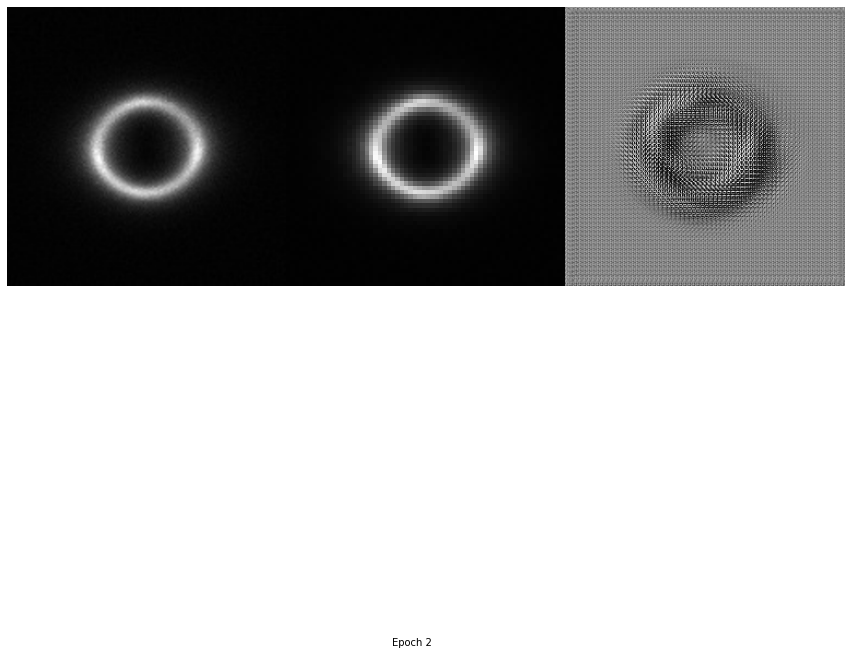

In [14]:
train_gen_losses, train_disc_losses, train_counter = [], [], []
test_gen_losses, test_disc_losses = [], []
test_counter = [idx*len(train_dataloader.dataset) for idx in range(1, n_epochs+1)]
BA = -1000
for epoch in range(1):
    count = 0
    ### Training
    gen_loss, disc_loss = 0, 0
    tqdm_bar = tqdm(train_dataloader, desc=f'Training Epoch {epoch} ', total=int(len(train_dataloader)))
    for batch_idx, imgs in enumerate(tqdm_bar):
        generator.train(); discriminator.train()
        # Configure model input
        imgs_lr = Variable(imgs["lr"].type(Tensor))
        imgs_hr = Variable(imgs["hr"].type(Tensor))
        
        # Adversarial ground truths
        valid = Variable(Tensor(np.ones((imgs_lr.size(0), *discriminator.output_shape))), requires_grad=False)
        fake = Variable(Tensor(np.zeros((imgs_lr.size(0), *discriminator.output_shape))), requires_grad=False)
        
        
        ### Train Generator
        optimizer_G.zero_grad()
        
        # Generate a high resolution image from low resolution input
        gen_hr = generator(imgs_lr)
        #gen.append(gen_hr)
        
        # Adversarial loss
        loss_GAN = criterion_GAN(discriminator(gen_hr), valid)
        
        
        # Content loss
        gen_features = feature_extractor(gen_hr)
        real_features = feature_extractor(imgs_hr)
        
        loss_content = criterion_content(gen_features, real_features)

        # Total loss
        loss_G = loss_content + 1e-3 * loss_GAN
        loss_G.backward()
        optimizer_G.step()
        
  
        
        if(count%9000 == 0):
            plot_train_result(imgs_hr, imgs_lr, gen_hr) 
            
        count = count+1    

        ### Train Discriminator
        optimizer_D.zero_grad()
        # Loss of real and fake images
        loss_real = criterion_GAN(discriminator(imgs_hr), valid)
        loss_fake = criterion_GAN(discriminator(gen_hr.detach()), fake)
        # Total loss
        loss_D = (loss_real + loss_fake) / 2
        loss_D.backward()
        optimizer_D.step()

        gen_loss += loss_G.item()
        train_gen_losses.append(loss_G.item())
        disc_loss += loss_D.item()
        train_disc_losses.append(loss_D.item())
        train_counter.append(batch_idx*batch_size + imgs_lr.size(0) + epoch*len(train_dataloader.dataset))
        tqdm_bar.set_postfix(gen_loss=gen_loss/(batch_idx+1), disc_loss=disc_loss/(batch_idx+1))

        
        # Save image grid with upsampled inputs and SRGAN outputs
        if (count%500==0):
            imgs_lr = nn.functional.interpolate(imgs_lr, scale_factor=4)
            imgs_hr = make_grid(imgs_hr, nrow=1, normalize=True)
            gen_hr = make_grid(gen_hr, nrow=1, normalize=True)
            imgs_lr = make_grid(imgs_lr, nrow=1, normalize=True)
            img_grid = torch.cat((imgs_hr, imgs_lr, gen_hr), -1)
            save_image(img_grid, f"images/{batch_idx}.png", normalize=False)

            
        
        # Save model checkpoints
        if np.argmin(train_gen_losses) == len(train_gen_losses)-1:
            torch.save(generator.state_dict(), "saved_models/generator.pth")
            torch.save(discriminator.state_dict(), "saved_models/discriminator.pth")

        

# Plotting Train vs. Test Loss for Generator

In [15]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=train_counter, y=train_gen_losses, mode='lines', name='Train Generator Loss'))
fig.add_trace(go.Scatter(x=test_counter, y=test_gen_losses, marker_symbol='star-diamond', 
                         marker_color='orange', marker_line_width=1, marker_size=9, mode='markers', name='Test Generator Loss'))
fig.update_layout(
    width=1000,
    height=500,
    title="Train vs. Test Generator Loss",
    xaxis_title="Number of training examples seen",
    yaxis_title="Adversarial + Content Loss"),
fig.show()

# Plotting Train vs. Test loss for Discriminator

In [16]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=train_counter, y=train_disc_losses, mode='lines', name='Train Discriminator Loss'))
fig.add_trace(go.Scatter(x=test_counter, y=test_disc_losses, marker_symbol='star-diamond', 
                         marker_color='orange', marker_line_width=1, marker_size=9, mode='markers', name='Test Discriminator Loss'))
fig.update_layout(
    width=1000,
    height=500,
    title="Train vs. Test Discriminator Loss",
    xaxis_title="Number of training examples seen",
    yaxis_title="Adversarial Loss"),
fig.show()

In [17]:
os.mkdir('val_outputs')

# Calculating MSE, PSNR and SSIM metrics

In [63]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import numpy as np
import torch
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

def mse(img1, img2):
    """Calculate mean squared error between two images."""
    return np.mean((img1 - img2) ** 2)

def calculate_metrics(generator, test_dataloader):
    """Calculate MSE, SSIM, and PSNR for the generator on the test set."""
    # print(generator.shape)
    generator.eval()
    mse_score, ssim_score, psnr_score = 0, 0, 0
    batches = len(test_dataloader)
    with torch.no_grad():
        for batch_idx, imgs in enumerate(test_dataloader):
            # Configure model input
            imgs_lr = imgs["lr"].type(torch.FloatTensor).to(device)
            imgs_hr = imgs["hr"].type(torch.FloatTensor).to(device)
            # print(f"imgs_lr:{imgs_lr.shape}\nimgs_hr:{imgs_hr.shape}")
            
            # Generate a high resolution image from low resolution input
            gen_hr = generator(imgs_lr)
            
            # Convert the generated image and ground truth to numpy arrays
            gen_hr_np = gen_hr.cpu().numpy().transpose(0, 2, 3, 1)
            imgs_hr_np = imgs_hr.cpu().numpy().transpose(0, 2, 3, 1)
            gen_hr_np=np.squeeze(gen_hr_np)
            imgs_hr_np=np.squeeze(imgs_hr_np)
            # print(f"imgs_hr_np:{imgs_hr_np.shape}\ngen_hr_np:{gen_hr_np.shape}")
            
            # Calculate metrics
            mse_score += mse(gen_hr_np, imgs_hr_np)
            ssim_score += ssim(gen_hr_np, imgs_hr_np, win_size=11, multichannel=True, data_range=1.0, channel_axis=1)
            psnr_score += psnr(gen_hr_np, imgs_hr_np, data_range=1.0)
    
    # Average the scores over all batches in the test set
    mse_score /= batches
    ssim_score /= batches
    psnr_score /= batches
    
    return mse_score, ssim_score, psnr_score


In [64]:
mse_score,ssim_score,psnr_score=calculate_metrics(generator,test_dataloader)
print(f"MSE: {mse_score}\nSSIM: {ssim_score}\nPSNR:{psnr_score}")

MSE: 0.0007601894683612045
SSIM: 0.8340342856645584
PSNR:32.14627635524643


# Saving the model to Google Drive

In [66]:
!cp -r /content/saved_models /content/gdrive/MyDrive/data